Using device: cpu
True damping coefficient μ = 4.0


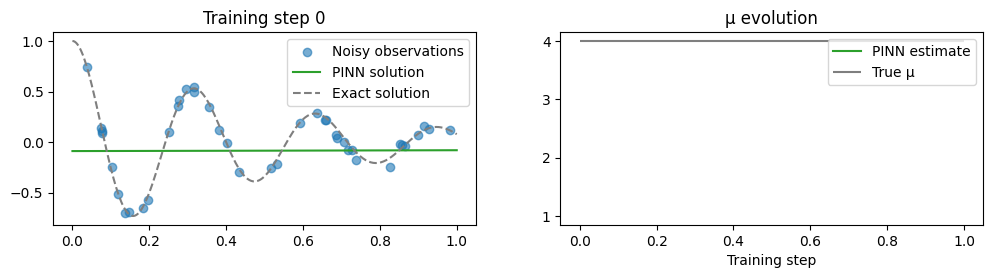

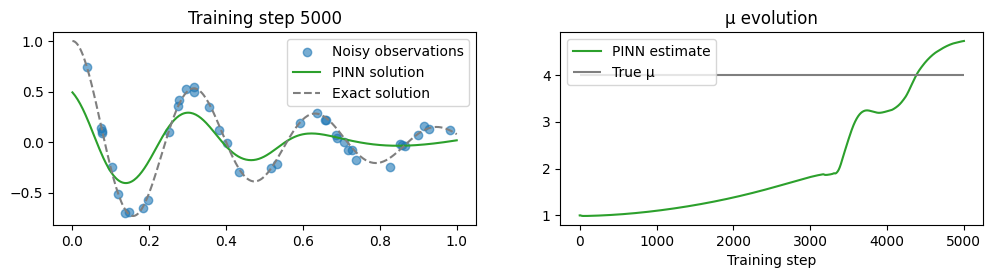

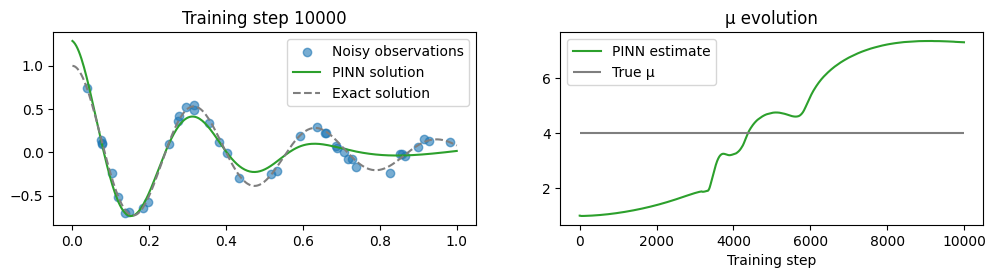

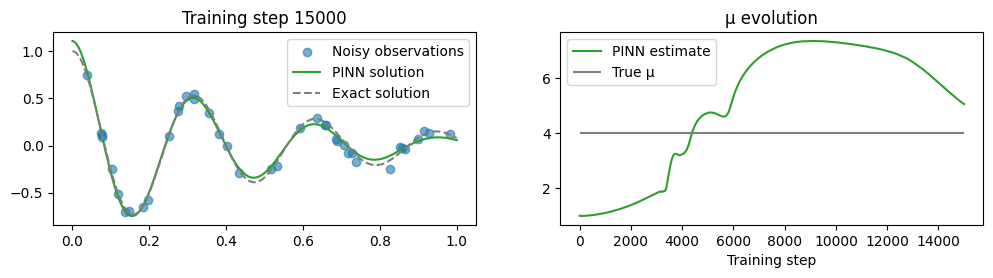

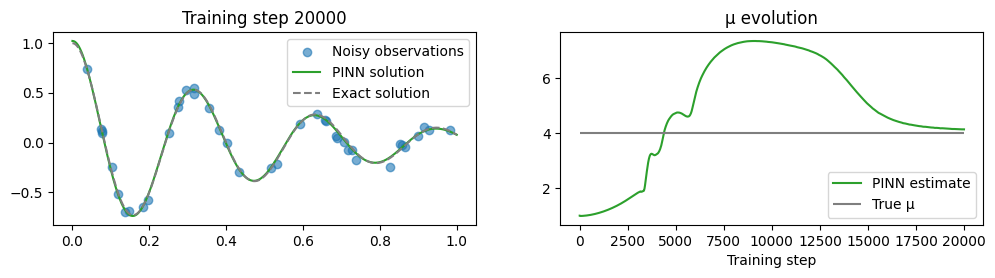

Estimated μ = 4.132 (true μ = 4.0)


In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# =====================================================
# Device setup
# =====================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.manual_seed(123)

# =====================================================
# Exact analytical solution (underdamped oscillator)
# =====================================================
def exact_solution(d, w0, t):
    """
    Returns the exact solution of an underdamped harmonic oscillator.
    u(t) = e^(-d*t) * A * cos(w*t + phi)
    """
    d = torch.tensor(d, dtype=torch.float32, device=t.device)
    w0 = torch.tensor(w0, dtype=torch.float32, device=t.device)
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.atan(-d / w)
    A = 1 / (2 * torch.cos(phi))
    return torch.exp(-d * t) * 2 * A * torch.cos(w * t + phi)

# =====================================================
# Fully Connected Neural Network
# =====================================================
class FCN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, number_hidden_layers):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(number_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# =====================================================
# Problem parameters
# =====================================================
d, w0 = 2.0, 20.0
true_mu = 2 * d
print(f"True damping coefficient μ = {true_mu}")

# Observational data (noisy)
t_data = torch.rand(40, 1)
u_noisy = exact_solution(d, w0, t_data) + 0.04 * torch.randn_like(t_data)

# Physics points (for residual calculation)
t_physics = torch.linspace(0, 1, 30, requires_grad=True).view(-1, 1)

# Test points for evaluation
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

# Move data to device
t_data, u_noisy = t_data.to(device), u_noisy.to(device)
t_physics, t_test, u_exact = t_physics.to(device), t_test.to(device), u_exact.to(device)

# =====================================================
# Initialize PINN and trainable damping parameter μ
# =====================================================
pinn = FCN(input_size=1, output_size=1, hidden_size=32, number_hidden_layers=3).to(device)
mu_pred = nn.Parameter(torch.tensor(1.0, device=device))  # trainable μ

# Optimizer
optimizer = optim.Adam(list(pinn.parameters()) + [mu_pred], lr=1e-3)

# =====================================================
# Training settings
# =====================================================
iterations = 20001
lambda_data = 1e4  # weight for data loss
losses, mus = [], []

# =====================================================
# Training loop
# =====================================================
for i in range(iterations):
    optimizer.zero_grad()

    # ----------------------------
    # Physics loss: ODE residual
    # ----------------------------
    u_phys = pinn(t_physics)
    dudt = torch.autograd.grad(u_phys, t_physics, torch.ones_like(u_phys), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    physics_loss = ((d2udt2 + mu_pred * dudt + w0**2 * u_phys)**2).mean()

    # ----------------------------
    # Data loss: fit to noisy observations
    # ----------------------------
    u_data = pinn(t_data)
    data_loss = ((u_data - u_noisy)**2).mean()

    # ----------------------------
    # Total loss
    # ----------------------------
    loss = physics_loss + lambda_data * data_loss
    loss.backward()
    optimizer.step()

    # Store metrics
    losses.append(loss.item())
    mus.append(mu_pred.item())

    # ----------------------------
    # Visualization every 5000 iterations
    # ----------------------------
    if i % 5000 == 0:
        u_test_pred = pinn(t_test).detach()

        plt.figure(figsize=(12, 2.5))

        # Plot PINN vs Exact
        plt.subplot(1, 2, 1)
        plt.scatter(t_data.cpu(), u_noisy.cpu(), label="Noisy observations", alpha=0.6)
        plt.plot(t_test.cpu(), u_test_pred.cpu(), label="PINN solution", color="tab:green")
        plt.plot(t_test.cpu(), u_exact.cpu(), "--", label="Exact solution", color="tab:grey")
        plt.title(f"Training step {i}")
        plt.legend()

        # Plot μ evolution
        plt.subplot(1, 2, 2)
        plt.title("μ evolution")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(true_mu, 0, len(mus), label="True μ", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()
        plt.show()

# =====================================================
# Final results
# =====================================================
print(f"Estimated μ = {mu_pred.item():.3f} (true μ = {true_mu})")